# Histopathologic Cancer Detection 

Lets just start with some imports straight away

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta

logger = logging.getLogger()

## Purpose and goal definition

Our purpose is to be able to identify metastatic cancer in small image patches taken from larger digital pathology scans, specifically of lymph node sections. Both of us were highly interested in medical, preferebly brain problem, but after not finding a good enough dataset on kaggle for brain pathologies we decided to go with the Histopathologic Cancer Detection dataset which spiked our interest. 

We believe solving these groups of problems is highly important. Being able to detect cancer using an algorithem can potentially shorten detection and diagnosis times, reduce human error and subsequentially save patient lives and reduce further complications.

### So why is solving the Histopathologic Cancer Detection dataset challenge so important?
The **lymph system** is a part of our immune system. It includes a network of lymph vessels and nodes. Lymph vessels are a lot like the veins that collect and carry blood through the body. But instead of carrying blood, these vessels carry the clear watery fluid called lymph. Lymph fluid also contains white blood cells, which help fight infections.

Cancer can appear in the lymph nodes in 2 ways: 
* start there (lymphoma)
* spread there from somewhere else.

In the case of this project it doesn't matter to us if it started there or spread there, the question is, is it there or not. 

Generally speaking, cancer in lymph nodes is hard to find. Normal lymph nodes are tiny and can be hard to find as is, but when there’s any kind of infection, inflammation, or cancer, the nodes can get larger. Those near the body’s surface often get big enough to feel with your fingers, and some can even be seen. But if there are only a few cancer cells in a lymph node, it may look and feel normal. Lymph nodes deep in the body cannot be felt or seen. **Essentially the only way to know whether there is cancer in a lymph node is to do a biopsy**. 

**Histopathology** is the diagnosis and study of diseases of the tissues in order to study the manifestation of different deseases, including cancer. It involves examining tissues and cells under a microscope, **a biopsy**. Histopathologists are doctors who are responsible for that study and the diagnoses that follows, they help clinicians manage a patient's care.

As we can assume, manual detection of a cancer cell is a tiresome task and involves human error. Most parts of the cell are frequently part of irregular random and arbitrary visual angles. As we already mentioned, the only way to detect cancer in a lymph node is using a biopsy. Machine learning algorithems can be applied to obtain better results as compared with manual pathological detection systems, this means that solving this challenge can be cruicial for lymph node cancer patients.  

**The goal** is to identify whether a tumor is benign or of a malignant in nature, malignant tumors are cancerous, which means they should be treated as soon as possible to reduce and prevent further complications. In other words we are dealing with a **binary classification problem**. 

## Data collection

Data was collected directly from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). It's a slightly modified version of the PCam dataset that can be found right [here](https://github.com/basveeling/pcam). The difference between the Kaggle version and the PCam ve

In [7]:
X_data_directory = "../../data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

In [8]:
y = pd.read_csv("../../data/histopathologic-cancer-detection/train_labels.csv")

In [9]:
y.shape

(220025, 2)

In [10]:
y.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

### Sort labels in alphanumeric order

In [11]:
y_sorted = y.sort_values('id')

In [12]:
y_sorted.head()

id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1
16166   000020de2aa6193f4c160e398a8edea95b1da598      0
87832   00004aab08381d25d315384d646f5ce413ea24b1      0
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0
128953  0000da768d06b879e5754c43e2298ce48726f722      1

In [13]:
y_sorted.tail()

id  label
175454  fffe6c73afcf5f5da5818fb70cb723026b172eca      0
168161  fffeb3f5361ea57e728fb689e6be34d07d16ca7e      0
39707   fffeca85b16452a7709d163e05a70e646782b3cc      1
208140  fffeeb1297fd4e26f247af648a2a6f942dfa2e9d      1
129173  ffffe55093358954f38bba4c35b6aa0ece86177c      0

### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [14]:
y_sorted.loc[y_sorted['label'] == 0,'translated_label'] = 'False'
y_sorted.loc[y_sorted['label'] == 1,'translated_label'] = 'True'

y_sorted["file_name"] = y_sorted["id"].astype(str) + ".tif"

In [15]:
y_sorted.head()

id  label translated_label  \
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1             True   
16166   000020de2aa6193f4c160e398a8edea95b1da598      0            False   
87832   00004aab08381d25d315384d646f5ce413ea24b1      0            False   
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0            False   
128953  0000da768d06b879e5754c43e2298ce48726f722      1             True   

                                           file_name  
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif  
16166   000020de2aa6193f4c160e398a8edea95b1da598.tif  
87832   00004aab08381d25d315384d646f5ce413ea24b1.tif  
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif  
128953  0000da768d06b879e5754c43e2298ce48726f722.tif

### Lets explore our labels

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This is however not a requirement for the PCam benchmark.

In the original dataset the labels were balances between True and False and also contained information regarding the cancel in general (ie Is it cancerour? Is only the center canceros?). Kaggle removed that extra bit of information and in addition removed duplicates from the dataset.


In [16]:
y_sorted.count()

id                  220025
label               220025
translated_label    220025
file_name           220025
dtype: int64

We can see that there are indeed no duplicates, even after dropping duplications the data stayed the same.

In [17]:
y_sorted.drop_duplicates()

id  label translated_label  \
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1             True   
16166   000020de2aa6193f4c160e398a8edea95b1da598      0            False   
87832   00004aab08381d25d315384d646f5ce413ea24b1      0            False   
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0            False   
128953  0000da768d06b879e5754c43e2298ce48726f722      1             True   
...                                          ...    ...              ...   
175454  fffe6c73afcf5f5da5818fb70cb723026b172eca      0            False   
168161  fffeb3f5361ea57e728fb689e6be34d07d16ca7e      0            False   
39707   fffeca85b16452a7709d163e05a70e646782b3cc      1             True   
208140  fffeeb1297fd4e26f247af648a2a6f942dfa2e9d      1             True   
129173  ffffe55093358954f38bba4c35b6aa0ece86177c      0            False   

                                           file_name  
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif  
16166   000020de2aa6193f4c160e398a8edea95b1da598.tif  
87832   00004aab08381d25d315384d646f5ce413ea24b1.tif  
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif  
128953  0000da768d06b879e5754c43e2298ce48726f722.tif  
...                                              ...  
175454  fffe6c73afcf5f5da5818fb70cb723026b172eca.tif  
168161  fffeb3f5361ea57e728fb689e6be34d07d16ca7e.tif  
39707   fffeca85b16452a7709d163e05a70e646782b3cc.tif  
208140  fffeeb1297fd4e26f247af648a2a6f942dfa2e9d.tif  
129173  ffffe55093358954f38bba4c35b6aa0ece86177c.tif  

[220025 rows x 4 columns]

There are no duplicates based purely on image id either

In [18]:
y_sorted.groupby('id').filter(lambda x: len(x) > 1)

Empty DataFrame
Columns: [id, label, translated_label, file_name]
Index: []

### Visualizing class labels distribution

<AxesSubplot:xlabel='translated_label', ylabel='count'>

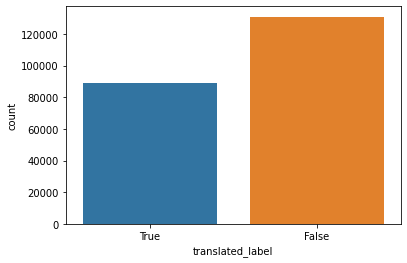

In [19]:
sns.countplot(data=y_sorted, x='translated_label')

We can see that after removing the duplications we have a bit of a skew between the labels. There are slightly more False labels than True labels. Lets look at the skew metric

In [20]:
y_sorted['label'].skew()

0.38692104417661555

We can see that the metric shows us that the labels distribution is fairly symmetrical. We'll keep it as is, and use oversampling in case we see problems with this balance in the future.

### Lets explore the data

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

In [21]:
file_name = y_sorted.iloc[[0]]['file_name'].iloc[0]
file_path = f"{X_data_directory}{file_name}"

img = plt.imread(file_path)

img.shape

(96, 96, 3)

From the shape we can see that our images are 96x96 with three color channels. Lets visualy some images and their labels.

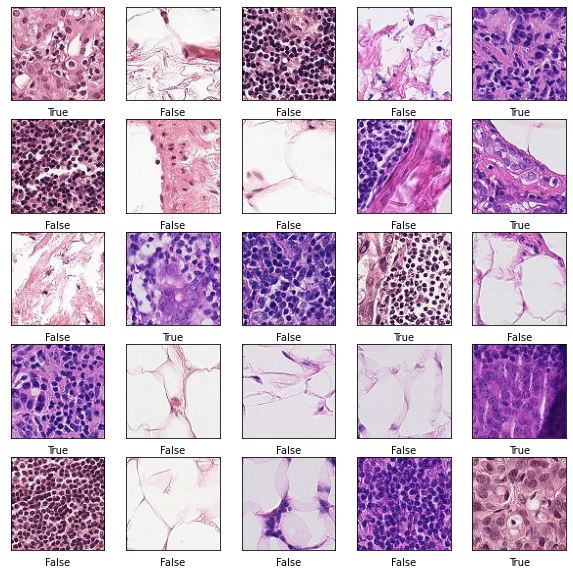

In [23]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = y_sorted.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


## Exploring low/high contract images

In [24]:
from skimage.exposure import is_low_contrast

In [25]:
def is_low_contrast_func(file_name):
    return is_low_contrast(plt.imread(f'{X_data_directory}{file_name}'), fraction_threshold=0.3)

In [26]:
y_sorted['is_low_contrast'] = y_sorted['file_name'].apply(func=is_low_contrast_func)

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

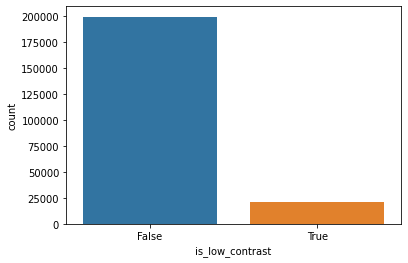

In [27]:
sns.countplot(data=y_sorted, x='is_low_contrast')

In [28]:
y_sorted.sort_values(['is_low_contrast']).tail()

id  label translated_label  \
210840  5eacf07fb2167c7bef34787a7b8481dc7936e547      0            False   
208416  218a405c52d67579decc3ae548dcad83fe266623      1             True   
194203  980fa63443b3625a4ce17e4a58ea350d0899ef41      0            False   
204638  5eb8ed482d161f30b5d83120348c8452340af080      0            False   
59514   7a0f68780244d9df830348fe6b49ec9f62f22809      0            False   

                                           file_name  is_low_contrast  
210840  5eacf07fb2167c7bef34787a7b8481dc7936e547.tif             True  
208416  218a405c52d67579decc3ae548dcad83fe266623.tif             True  
194203  980fa63443b3625a4ce17e4a58ea350d0899ef41.tif             True  
204638  5eb8ed482d161f30b5d83120348c8452340af080.tif             True  
59514   7a0f68780244d9df830348fe6b49ec9f62f22809.tif             True

In [29]:
low_contrast_img_df = y_sorted[y_sorted['is_low_contrast'] == True]

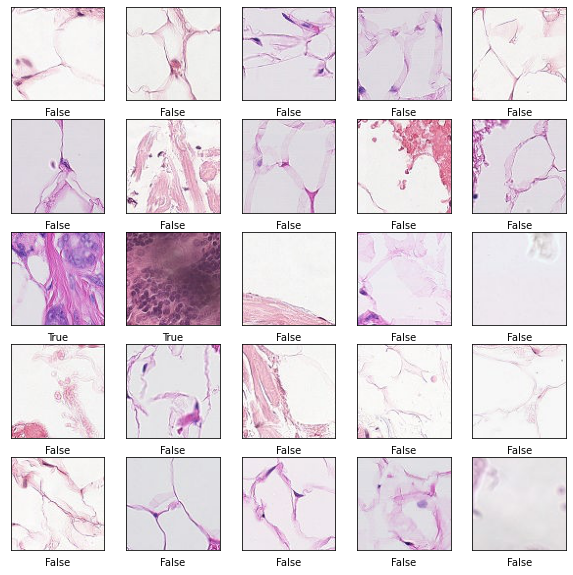

In [30]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = low_contrast_img_df.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

To the naked eye it seems that the threshold of 0.3 is too high. Let's try lowering that threshold.

In [31]:
def is_low_contrast_func_01(file_name):
    return is_low_contrast(plt.imread(f'{X_data_directory}{file_name}'), fraction_threshold=0.1)

In [ ]:
y_sorted['is_low_contrast_01'] = y_sorted['file_name'].apply(is_low_contrast_func_01)

In [ ]:
sns.countplot(data=y_sorted, x='is_low_contrast_01')

In [ ]:
low_contrast_img_df = y_sorted[y_sorted['is_low_contrast_01'] == True]

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = low_contrast_img_df.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

## Load image train set

The data format we're dealing with here if tif. For this reason we can't use the image_dataset_from_directory provided by Keras. Instead we're going to use the ImageDataGenerator with

In [169]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [170]:
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip image

In [171]:
batch_size=1

In [211]:
train_set = datagen.flow_from_dataframe(
        dataframe=y_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42, 
        batch_size=batch_size,
        validation_split=0.3,
        subset="training",
        class_mode='binary') 



Found 154018 validated image filenames belonging to 2 classes.


In [173]:
val_set = datagen.flow_from_dataframe(
        dataframe=y_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42,
        batch_size=batch_size,
        validation_split=0.3,
        subset="validation",
        class_mode='binary') 
print(val_set)

Found 66007 validated image filenames belonging to 2 classes.


### Determining the size of the batch
So at this point we've actually inncountered a bug with Keras, we got a pretty ugly exception if we'd set the batch size to be any number aside from 1. But then also not setting "steps_per_epoch" would put us in a bad position. 

Calculating the following metrics proves to be the samme as len(train_set). So using this setting the "steps_per_epoch" is running a single image per set per the entire dataset. 

In [174]:
train_steps_per_epoch = np.ceil(train_set.n / train_set.batch_size )

In [175]:
train_steps_per_epoch

154018.0

In [176]:
len(train_set)

154018

## Building our model

In [203]:
model = models.Sequential()
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
input_shape = (1, 96, 96, 3)
model.add(layers.Input(shape=input_shape))
model.add(layers.Conv2D(16,(3,3),strides=(1,1),padding='Same',activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,(3,3), strides=(1,1),padding= 'Same', activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,(3,3), strides=(1,1),padding= 'Same', activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [204]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_84 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_85 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                     

## Compiling and fitting our model

In [123]:
#
#model.compile(optimizer=optimizer,
              #loss='binary_crossentropy',
              #metrics=['accuracy'])

In [205]:
history = model.fit(train_set, epochs=5,batch_size=1, steps_per_epoch=len(train_set),
                    validation_data=(val_set),verbose=1)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_26/flatten_25/Reshape' defined at (most recent call last):
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/runpy.py", line 193, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/traitlets/config/application.py", line 965, in launch_instance
      app.start()
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_31916/56660557.py", line 1, in <cell line: 1>
      history = model.fit(train_set, epochs=5, steps_per_epoch=len(train_set),
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alexakh/Library/Python/3.8/lib/python/site-packages/keras/layers/reshaping/flatten.py", line 98, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_26/flatten_25/Reshape'
Input to reshape is a tensor with 65536 values, but the requested shape requires a multiple of 9216
	 [[{{node sequential_26/flatten_25/Reshape}}]] [Op:__inference_train_function_48939]

Looking at the first epoch we've noticed the loss and accuracy don't really change afte raround 50-60K images